<font size=6>**Classical Statistics: Likelihood and Hypothesis Testing**</font>


## Why we need to test hypotheses and estimate parameters

**Observations** are a means to measure the properties of natural objects, and provide insights for new theories.

**Theories** are **potential** models describing how the Universe works under certain conditions. **Good theories** come with predictions on the observed properties of objects.

In order to really learn something new about the Universe we need to test 
- whether our new theory agree with the (preferably new) data (Hypothesis testing), or
- which theory is more probably (Model Comparison), or
- what are the probably parameters of an existing theory so that it explains the data (Inference on parameters)

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Constraining the parameter of a theory: Maximum Likelihood Estimation

Globular clusters are dense systems of stars that are found in almost all galaxies. They look red, so they are expected to be dominated by old stars. From stellar evolution we know that old stars are small in mass, and cold: they cover a small range in masses, and their emission is peaking at the near infrared.

Therefore, we expect that the mass of a globular cluster is correlated with their luminosity in the K-band in the near infrared:

$$\Large M = \Upsilon L_K $$

If we find the proportionallity constant $\Upsilon$, the characteristic *mass-to-light ratio* of globular clusters, we will be able to measure masses of globular clusters by measuring their luminosity.



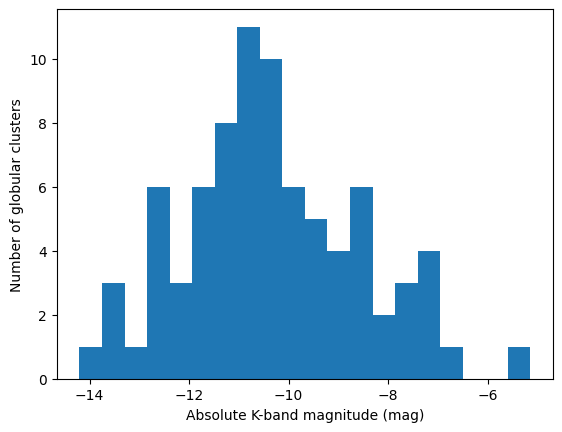

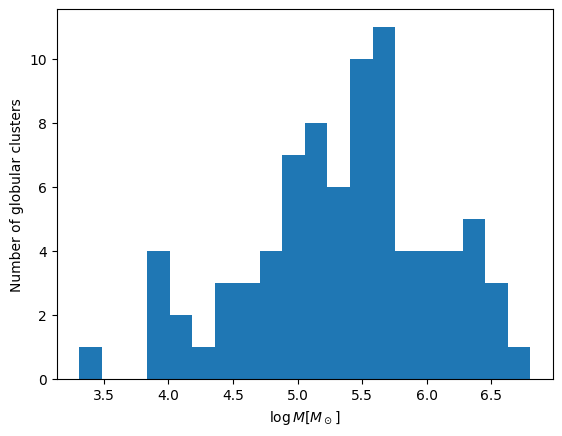

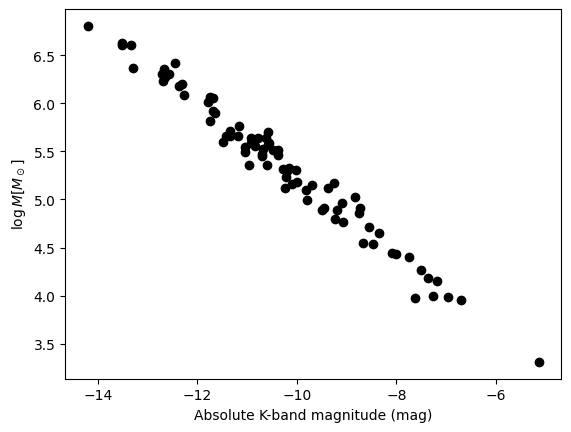

In [51]:
K_absolute_magnitudes = np.genfromtxt("data/GC_MWG_absolute.csv")
masses = np.genfromtxt("data/GC_MWG_masses.csv")
log_masses = np.log10(masses)


plt.figure()
plt.hist(K_absolute_magnitudes, bins=20)
plt.xlabel("Absolute K-band magnitude (mag)")
plt.ylabel("Number of globular clusters")
plt.show()

plt.figure()
plt.hist(log_masses, bins=20)
plt.xlabel("$\log M [M_\odot]$")
plt.ylabel("Number of globular clusters")
plt.show()

plt.figure()
plt.plot(K_absolute_magnitudes, log_masses, "ko")
plt.xlabel("Absolute K-band magnitude (mag)")
plt.ylabel("$\log M [M_\odot]$")
plt.show()

The K-band luminosity can be calculated (in solar units) from the absolute magnitudes, $M_K$, using the formula:

$$\Large \frac{L}{L_\odot} = 10^{0.4\left(M_{K,\odot}-M_K\right)} $$

where $M_{K,\odot}$ is the absolute K-band magnitude of the sun.

In [53]:
def get_K_band_luminosity(absolute_magnitudes):
    M_K_SOLAR = 3.29   # Blanton & Roweis (2007)
    return 10.0 ** (0.4 * (M_K_SOLAR - absolute_magnitudes))

def get_masses_from_K(absolute_magnitudes, mass_to_light_ratio):
    # compute the K-band luminosity (in solar units)
    # use the luminosity to estimate the mass
    K_band_luminosity = get_K_band_luminosity(absolute_magnitudes)
    return mass_to_light_ratio * K_band_luminosity

## 1.1 Constructing a likelihood function

Our problems falls into the general case where we have a model connecting two quantities through a function which has one parameter, $\theta$ (in our case the M/L ratio):

$$ \Large y = f(x; a) $$

Therefore, if we get $N$ data, $(x_i, y_i)$ for $i \in [1, 2, \cdots, N]$ based on the model we would expect:

$$\Large y_i = f(x_i; a) $$

However, all observations are **subject to an uncertainties**, and we need to model this as well. In most cases, the uncertainties are fluctuations of a certain magnitude $\sigma$ around 0, following the Gaussian distribution:

$$\Large y_i = f(x_i) + \epsilon_i $$

where $\epsilon_i$ is normally distributed:

$$\Large \epsilon \sim \mathcal{N}(0, \sigma)$$

The $\sigma$ is the standard deviation, or a typical difference between the observed $y_i$ and the intrinsic, true value $y_i$ which we **assume that is described by the model**.

Consequently, according to our model, the probability to observe the $i$-th point's $y$-value, or the **datum likelihood** is

$$\Large
P(y_i) = \text{Norm}(f(x_i), \sigma) 
   = \dfrac{1}{\sqrt{2\pi \sigma^2}} \exp \left[{-\dfrac{(y_i-f(x_i))^2}{2\sigma^2}} \right]
$$

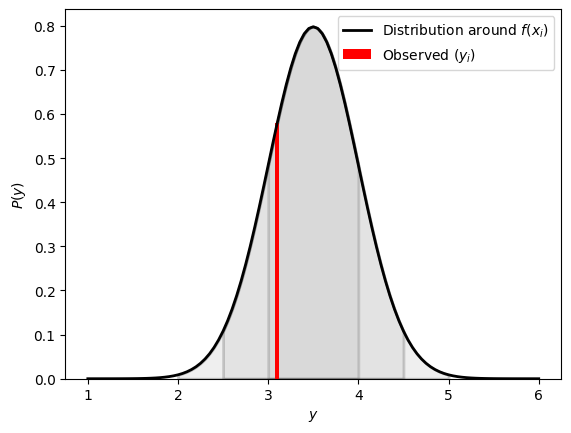

In [231]:
expected = 3.5
uncertainty = 0.5
observed = 3.1
distribution = st.norm(expected, uncertainty)
x_plot = np.linspace(expected-5*uncertainty, expected+5*uncertainty, 101)
y_plot = distribution.pdf(x_plot)
plt.figure()
for sigma in [1, 2, 3]:
    x_in_sigma = np.linspace(expected-sigma*uncertainty, expected+sigma*uncertainty, 101)
    y_in_sigma = distribution.pdf(x_in_sigma)
    plt.fill_between(x_in_sigma, 0.0, y_in_sigma, ls="-", edgecolor="k", lw=2, facecolor="0.7", alpha=0.2)
plt.plot(x_plot, y_plot, "k-", lw=2, label="Distribution around $f(x_i)$")
plt.bar(observed, height=distribution.pdf(observed), color="r", width=0.05, label="Observed ($y_i$)")
plt.ylim(ymin=0)
plt.xlabel("$y$")
plt.ylabel("$P(y)$")
plt.legend(loc="upper right")
plt.show()

Assuming that our measurement are independent (the probability of $y_2$ does not depend on $y_1$), the overall probability to get our data, or **likelihood** (always **according to our model**) is the product of all likelihoods:

$$\large L = \prod_{i=1}^{N} P(y_i)$$

Let's do the math...

$$\large
L = \prod_{i=1}^{N} \dfrac{1}{\sqrt{2\pi \sigma^2}} \exp \left[{-\dfrac{(y_i-f(x_i))^2}{2\sigma^2}} \right]
$$

$$\large
L = \left(\dfrac{1}{\sqrt{2\pi \sigma^2}}\right)^N \exp \left[ -\sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{2\sigma^2}} \right]
$$

$$\large
L = \left(\dfrac{1}{\sqrt{2\pi \sigma^2}}\right)^N \exp \left[ -\dfrac{1}{2\sigma^2} \sum_{i=1}^{N} (y_i-f(x_i))^2 \right]
$$

Since the likelihood is a very small, but positive quantity, we can work in log-space:

$$\large
l = \ln{L} = -\frac{N}{2} \ln\left(2\pi \sigma^2\right) -\dfrac{1}{2\sigma^2} - \sum_{i=1}^{N} (y_i-f(x_i))^2
$$

If we don't care about the normalization of the likelihood, then we can ignore the constant terms in $l$:

$$\large
l' = -\sum_{i=1}^{N} (y_i-f(x_i))^2
$$


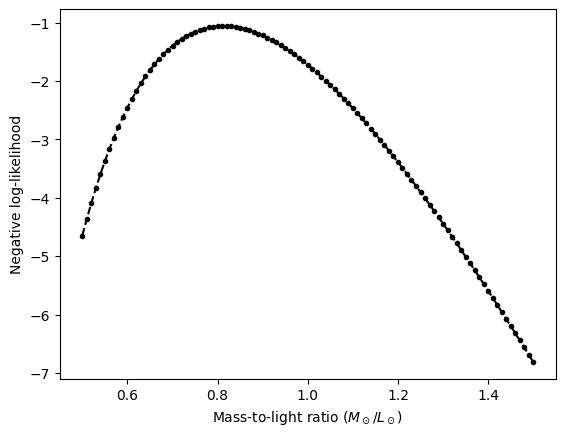

In [54]:
def log_likelihood(mass_to_light_ratio, absolute_magnitudes, observed_log_masses):
    expected_masses = get_masses_from_K(absolute_magnitudes, mass_to_light_ratio=mass_to_light_ratio)
    expected_log_masses = np.log10(expected_masses)
    return -np.sum((expected_log_masses - observed_log_masses) ** 2.0)


ml_ratios = np.linspace(0.5, 1.5, 101)
log_likelihoods = [log_likelihood(ml, K_absolute_magnitudes, log_masses) for ml in ml_ratios]
plt.figure()
plt.plot(ml_ratios, log_likelihoods, "k.--")
plt.xlabel("Mass-to-light ratio ($M_\odot / L_\odot$)")
plt.ylabel("Negative log-likelihood")
plt.show()

## 1.2 Maximizing the likelihood: analytically

We can get the best-fitting values of the parameters of a model by maximizing the likelihood function. Analyticall this is done by solving

$$\Large \frac{\partial L}{\partial \theta_i} = 0 $$

for all parameters $\theta_i$ of the model. Typically we need to also ensure that the solution(s) $\theta'$ of the above equation (or system) is (are) a maximum by proving that

$$\Large \frac{\partial^2 L}{\partial \theta^2}(\theta') < 0 $$


## Maximizing the likelihood: numercially

In practice, likelihood functions may be such that an analytical solution does not exist. No worries, we can always use numerical approches which work pretty well and fast for low-dimensional cases (1-3 parameters). Note that `scipy` provides powerful methods to **minimize** functions.

In [58]:
from scipy.optimize import minimize_scalar

def function_to_minimize(parameter):
    return -log_likelihood(parameter, absolute_magnitudes=K_absolute_magnitudes, observed_log_masses=log_masses)

minimization_outcome = minimize_scalar(function_to_minimize, bounds=[0.0, 3.0])
print("Minimization outcome:")
print(minimization_outcome)

solution = minimization_outcome.x
true_ML = 0.822                         # Kovlakas et al. 2021

print()
print(f"Best-fitting M/L ratio : {minimization_outcome.x:.4f}")
print(f"True value             : {TRUE_MEAN_MASS_TO_LIGHT_RATIO:.4f}")
print(f"Relative difference    : {100.0*(solution - true_ML) / true_ML:.2f}%")

Minimization outcome:
 message: Solution found.
 success: True
  status: 0
     fun: 1.0571633335223158
       x: 0.8118843960553855
     nit: 12
    nfev: 12

Best-fitting M/L ratio : 0.8119
True value             : 0.8220
Relative difference    : -1.23%


<font size=3><u>**In-class discussion: would we get the same result by fitting with ordinary least-squares?**</u><font>

_Discuss a few mins with your teammate, then report.  Think of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
A least-squares fit is what we did! We minimized -$f(\theta)$ where $f(\theta)$ is the negative sum of square differences between the prediction (from $\theta$) and the observations!
<br>

<font size=3><u>**In-class discussion: if yes, is it because the data appear to have a linear correlation?**</u><font>

_Discuss a few mins with your teammate, then report.  Think of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The fact that we perform a least-squares fit (numerically rather than analytically) is a consequence of the likelihood function, not the form of the data! The assumptions of least-squares method (e.g., linear parameters in the model, Gaussian residuals around 0, independent samples, etc.) are the same with the ones we made!

It's not difficult to imagine cases where the there is linear correlation, but the likelihood would have to be different: number of stars vs. mass of a galaxy.
<br>

# Hypothesis testing

**Definition**

Hypothesis testing is the process of testing an assumption regarding a parameter of a population using a sample of the population.

> Example: Verifying a model for the mass of globular clusters (GC)

## The theoretical model

Globis & Clusterton (2022) used hydrodynamical galaxy simulations to model the formation of globular clusters (GC) in a galaxy like the Milky Way. They found that the masses of the GCs are described by a Gaussian distribution:

$$\large \log_{10} \left(\frac{M}{M_\odot}\right) \sim \mathcal{N}(5.5, 1) $$

meaning that the mean mass is $10^{5.5} M_\odot \simeq 3.2\times 10^5 M_\odot$ and the typical scatter is $1 \mathrm{dex}$ (one order of magnitude).

(or an order of magnitude).

Let's see this the model alogn with the data

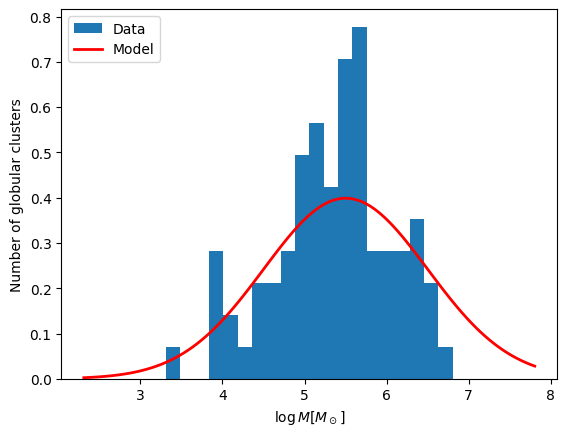

In [66]:
import scipy.stats as st

model_mean = 5.5
model_std = 1.0

logm_for_plot = np.linspace(min(log_masses)-1, max(log_masses)+1, 100)
model_prob_for_plot = st.norm(model_mean, model_std).pdf(logm_for_plot)

plt.figure()
plt.hist(log_masses, bins=20, density=True, label="Data")
plt.plot(logm_for_plot, model_prob_for_plot, "r-", lw=2, label="Model")
plt.xlabel("$\log M [M_\odot]$")
plt.ylabel("Number of globular clusters")
plt.legend(loc="upper left")
plt.show()

In [71]:
sample_mean = np.mean(log_masses)
sample_std = np.std(log_masses)

print(f"MODEL:  Mean = {model_mean:.2f} | Std = {model_std:.2f}")
print(f"SAMPLE: Mean = {sample_mean:.2f} | Std = {sample_std:.2f}")

MODEL:  Mean = 5.50 | Std = 1.00
SAMPLE: Mean = 5.35 | Std = 0.72


<font size=3><u>**In-class discussion: is the sample mean close to the model's value?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
There is no right answer... it is subjective. Our goal here is to quantify this "subjectiveness"!
<br>

<font size=3><u>**In-class discussion: does the standard deviation give a sense of how close the mean values are?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Not exactly. The standard deviation describes the scatter of the data. Itself does not say much about the mean value of the sample.
<br>


## 1.5 Standard error of the mean

Whether the mean values are close depends also on the sample size. The larger it is, the more accurate our estimate on the mean is, so we would expect to converge to the mean of the underlying population. 

For normally distributed data the **standard deviation of the mean** scales as:

$$ \large \sigma_{\bar{x}} = \frac{\sigma}{\sqrt{N}} $$

where $\sigma$ is the population standard deviation and $N$ is the sample size.

In most cases, the population deviation is unknown. For this reason, we use the same sample to estimate it, calculating the *sample standard deviation $s$*. The equivalent quantity is called **standard error on the mean**:

$$ \large s_{\bar{x}} = \frac{s}{\sqrt{N}} $$

The sample mean is considered to be normally distributed, and therefore we can calculate the number of standard errors the sample mean is away from the theoretical value, or the **sigmas**.

Standard error of the mean = 0.08
Sigma's of difference      : 1.80


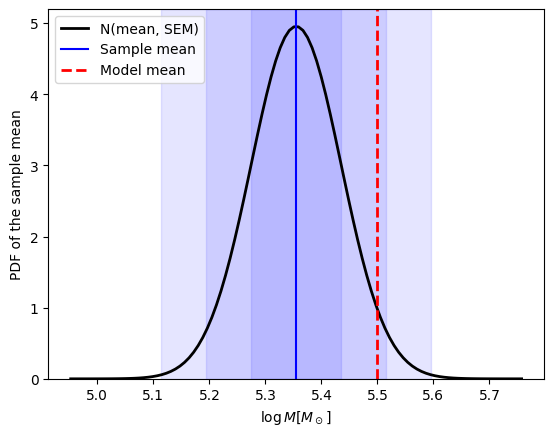

In [75]:
sample_sem = st.sem(log_masses)
print(f"Standard error of the mean = {sample_sem:.2f}")
print(f"Sigma's of difference      : {(model_mean-sample_mean) / sample_sem:.2f}")

x_plot = np.linspace(sample_mean - 5 * sample_sem, sample_mean + 5 * sample_sem, 100)
mean_distribution = st.norm(sample_mean, sample_sem)
y_plot = mean_distribution.pdf(x_plot)
plt.figure()
plt.plot(x_plot, y_plot, "k-", lw=2, label="N(mean, SEM)")
plt.axvline(sample_mean, ls="-", color="b", label="Sample mean")
plt.axvline(model_mean, ls="--", lw=2, color="r", label="Model mean")
for sigmas in [1, 2, 3]:
    plt.axvspan(sample_mean - sigmas*sample_sem, sample_mean + sigmas*sample_sem, color="b", alpha=0.1)
plt.legend(loc="upper left")
plt.ylim(ymin=0.0)
plt.xlabel("$\log M [M_\odot]$")
plt.ylabel("PDF of the sample mean")
plt.show()

But is this difference small enough to accept the model? 

## When to reject a model...

One might argue that if the theoretical mean is too extreme, either **too low** or **two high**, we should **reject the hypothesis theat the model describes the data**. 

Therefore we can calculate from the distribution what is the probability of such extreme values around the sample mean.

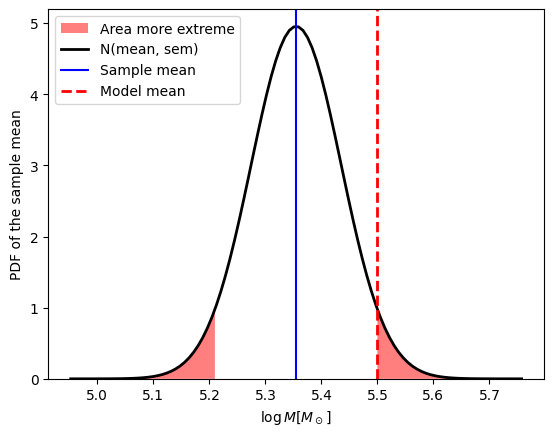

In [78]:
x_plot = np.linspace(sample_mean - 5 * sample_sem, sample_mean + 5 * sample_sem, 100)

diff = abs(sample_mean - model_mean)
xx_before = np.linspace(sample_mean - 5 * sample_sem, sample_mean - diff, 100)
xx_after = np.linspace(sample_mean + diff, sample_mean + 5 * sample_sem, 100)

mean_distribution = st.norm(sample_mean, sample_sem)
y_plot = mean_distribution.pdf(x_plot)

plt.figure()
plt.fill_between(xx_before, mean_distribution.pdf(xx_before), 0, color="r", ec="none", alpha=0.5, label="Area more extreme")
plt.fill_between(xx_after, mean_distribution.pdf(xx_after), 0, color="r", ec="none", alpha=0.5)
plt.plot(x_plot, y_plot, "k-", lw=2, label="N(mean, sem)")
plt.axvline(sample_mean, ls="-", color="b", label="Sample mean")
plt.axvline(model_mean, ls="--", lw=2, color="r", label="Model mean")
# for sigmas in [1, 2, 3]:
#     plt.axvspan(sample_mean - sigmas*sample_sem, sample_mean + sigmas*sample_sem, color="b", alpha=0.1)
plt.legend(loc="upper left")
plt.ylim(ymin=0.0)
plt.xlabel("$\log M [M_\odot]$")
plt.ylabel("PDF of the sample mean")
plt.show()

The cumulative distribution function is

$$ \large F(x) = \int\limits_{-\infty}^{x} f(x') dx' $$
and therefore the "area more exteme" is the probability 

$$
\begin{align}
\large p   
    &= \large 1 - \textrm{(area between)} = \\
    &= 1 - \int\limits_{m-d}^{m+d} f(x') dx' = \\
    &= 1 - \left(\int\limits_{-\infty}^{m+d} f(x')dx' - \int\limits_{\infty}^{m-d} f(x')dx' \right) = \\
    &= \large 1 - \left[F(m+d) - F(m-d)\right]
\end{align}
$$

which in our case is...

In [80]:
area_more_extreme = 1 - (mean_distribution.cdf(sample_mean+diff) - mean_distribution.cdf(sample_mean-diff))
print(f"Area more extreme, p = {area_more_extreme:.3f}")

Area more extreme, p = 0.072


In other words, there is an 8% probability, or **$p$-value**, to reject this model even if it is correct. *Can we risk it*? It is **our choice** to consider our "threshold"!

If we had decided **before looking at the data** to use a 5% threshold, then our conclusion is that 

> *we do not reject the model, with a significance level of 5%".*

Notice that we **do not accept** the model!!! There are infinite other models under which the $p$-value above will be above our threshold. For example, $N(5.5, 0.101)$, $N(5.51, 0.1)$, ...

On the other hand, if we had found $p=0.0001$ or our threshold was 0.01%, then we would **reject the model** given the sample at hand.

There is no rule on what the significance level should be. Just that is should be decided before looking at the data, to avoid, **as humans, bias our conclusions by relaxing our criteria for models we like, or making them harder for models we don't!**

In disciplines that are characterized by inaccuracies or complexities, it is often 1, 5, or 10%. In precision experiments in nuclear physics, often $10^{-7}$ or $10^{-10}$ is used!

Since the $p$-value is connected to the difference's number of sigmas, often we refer the *sigmas* instead of the actual probability - it is shorter to say, and it is easier to "imagine" it in plots with error bars and distributions. For example:

| Sigmas | Probability (inside) | Probability (outside) |
| --- | --- | --- |
|  1 | 0.68 | 0.32 |
|  2 | 0.954 | 0.046 |
|  3 | 0.9973 | 0.0027 |
|  5 | 0.9999994 | 0.0000006 |
|  8 | 0.9999999999999987 | 0.0000000000000013

## In the language of Statistics: *Hypothesis testing*

> **Step 1**: We define the **null hypothesis** or the statement that we will test (a model or random outcome)

> **Step 2**: We decide on a **significance level** - or what is the "probability for being wrong in rejecting the null hypothesis" which we are comfortable with?

> **Step 3**: The **statistic** - or a quantitiy that is computed on our *sample* assuming the *hypothesis is true*

> **Step 4**: **$p$-value** and **critical value**: compute the "probability of being wrong" or the value of the statistic based on which we will reject the hypothesis or not

> **Step 5**: the decision!


### Step 1. We define the null hypothesis

> $H_0$: the mean value of the decimal logarithm of the masses of Milky Way GCs is consistent with the model

### Step 2. We decide on a significance level

This is the probability for rejecting the null hypothesis if it is true - the "probability of being wrong" if we reject the hypothesis at the end.

> Let's take a significance level of $5\%$, i.e. $a = 0.05$

### Step 3. The statistic, $Z$-score

In order to decide whether the sample mean is consistent with the model's prediction, we must compute the **distribution of the sample mean given that the model is correct.**

For $N$ observations $x_i$ the sample mean, $\bar{x}$ is

$$ \bar{x} = \frac{1}{N} \sum\limits_{i=1}^{N} x_i$$

For normally distributed observations, $x_i \sim \mathcal{N}(\mu, \sigma)$, it is known that the sample mean is also normally distributed with mean equal to the population mean ($\mu$) and standard deviation equal to the population standard deviation ($\sigma$) devided by the square root of the size of the sample ($N$):

$$ \bar{x} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{N}\right)$$

...called *standard deviation of the mean*:

$$ \sigma_{\bar{x}} = \frac{\sigma}{\sqrt{N}}$$

Therefore the probability density function (PDF) of the sample mean is:

$$f(\bar{x}) = \frac{1}{\sqrt{2\pi \ \sigma_{\bar{x}}^2}} \exp\left[-\frac{\left(\bar{x} - \mu\right)^2}{2 \ \sigma_{\bar{x}}^2}\right]$$

Because of the ability to shift and scale the normal distribution, the quantity

$$ Z = \frac{\bar{x} - \mu}{\sigma_{\bar{x}}} $$

follows the standard normal distribution (i.e. mean value $0$ and standard deviation $1$):

$$ f(Z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}Z^2}$$

Therefore, by just computing the $Z$ *score* of our sample, $z$, we can easily use tables for the normal distribution or code to quickly compute the probability at which $Z$ is below or above a specific value.

We call this value $Z$ *statistic* or *score* and it used whenever the quantity we use to test the hypothesis is normally distributed.

### Step 4. $p$-value and critical value(s) for the statistic

<figure>
 <img src="images/two_tailed.png" alt="" width=500 />
 <figcaption>
 <center>Distribution of the statistic and critical values.</center>
 </figcaption>
</figure>

Because of the null hypothesis, we must convert the statement "*consistent with...*" to a mathematical statement. In this example, we can consider that the sample mean is inconsistent with the model prediction if its significantly lower or higher (see *two tail test* instead of *one tail test*).

Therefore, the Type I error is equal to probability that the $Z$ score deviates more than the absolute deviation of the score for the sample at hand:

$$ p = P(Z > |z|) + P(Z < -|z|) $$

Using the symmetry of normal distribution's PDF and the fact that $P({\rm A}) + P({\rm not\ A}) = 1$, we arrive at

$$ p = \cdots = 2 \left(1 - P\left(Z < |z|\right)\right) = \cdots = 2 P(Z < -|z|)$$

or simply,

$$ p = 2 \Phi(-|z|) $$

where $\Phi(z)$ is the CDF of the standard normal distirbution.

If we find $p < a = 0.05$ then we reject the null hypothesis.

Alternatively, we can set **critical** values of the $Z$ score that correspond to the significance level of choice. As rejection should occur either for higher or lower values (two-tailed test), we find two critical values corresponding to $a/2$ probability:

$$ Z_{\rm crit,1} = \Phi^{-1}\left(\frac{a}{2}\right) = -1.96 $$

$$ Z_{\rm crit,2} = \Phi^{-1}\left(1 - \frac{a}{2}\right) = +1.96 $$

Because of the symmetry of the normal distribution we could also compute a critical value for the absolute $Z$ score:

$$ |Z|_{\rm crit} = 1.96 $$

This is equivalent to asking *how many **sigmas** away from the model prediction can the measured value be in order to reject the null hypotheis?* Astronomers are used to use the $\sigma$ term: "we reject the hypothesis on a $2\sigma$ significance level!"

### Step 5. Decision

Now that we defined all the steps, we can apply it on the data. In the following code, we compute the statistic and print the outcome based on $p$-value. Alternatively we can use the critical value.

## 2.1 Let's do that with code! $Z$-test, assuming we know the population standard deviation

In [83]:
# set alpha and compute the critical value(s)
alpha = 0.05
print("Significance level: {:7.3f}".format(alpha))

# compute the p-value and report the result
sample_mean = np.mean(log_masses)
stddev_mean = model_std / (sample_size ** 0.5)
z_score = (sample_mean - model_mean) / stddev_mean
pvalue = 2 * st.norm(0, 1).cdf(-abs(z_score))

print("Sample mean       : {:7.3f}".format(sample_mean))
print("Standard error    : {:7.3f}".format(stddev_mean))
print("Sample Z score    : {:7.3f}".format(z_score))
print()
print("p-value           : {:7.3g}".format(pvalue))

if pvalue <  alpha:
    print("    ...we reject the null hypothesis. ****")
else:
    print("    ...we cannot reject the null hypothesis. ****")
    
print()

# alternatively we could compute the critical value and base our outcome on it
z_critical = abs(st.norm.ppf(alpha / 2.0))
print("Critical values   : {:7.3f} and {:.3f}".format(-z_critical, z_critical))
if abs(z_score) > abs(z_critical):
    print("    ...we reject the null hypothesis. ****")
else:
    print("    ...we cannot reject the null hypothesis. ****")

Significance level:   0.050
Sample mean       :   5.355
Standard error    :   0.111
Sample Z score    :  -1.306

p-value           :   0.192
    ...we cannot reject the null hypothesis. ****

Critical values   :  -1.960 and 1.960
    ...we cannot reject the null hypothesis. ****


## $t$-test

Above we used the theoretical value of $\sigma$ to calculate the $Z$-score. We **assumed** that we know the standard deviation of the population! In most cases, we don't!

Instead, we **estimate** the population parameter $\sigma$ from the standard deviation in the sample $s$.

*Caveat: we are using the same value to calculate the mean and the standard deviation - therefore there is one less degree of freedom in the statistic*:

$$ \large \text{dof} = n - 1 $$

> Is the mean value of a sample equal to the population mean (without knowing the population standard deviation)?

The distribution of the sample mean now follows the Student's $t$-distribution (after applying a shift and a rescale)

Specifically, the statistic is

$$ \large t = \frac{\bar{x} - \mu}{s / \sqrt{n}} $$

where $s$ is the sample standard deviation and takes the place of the population standard deviation in the $Z$-test we saw previously. The $t$-distribution is similar to the Gaussian but has 'heavier' tails when the sample size is small ($n$):

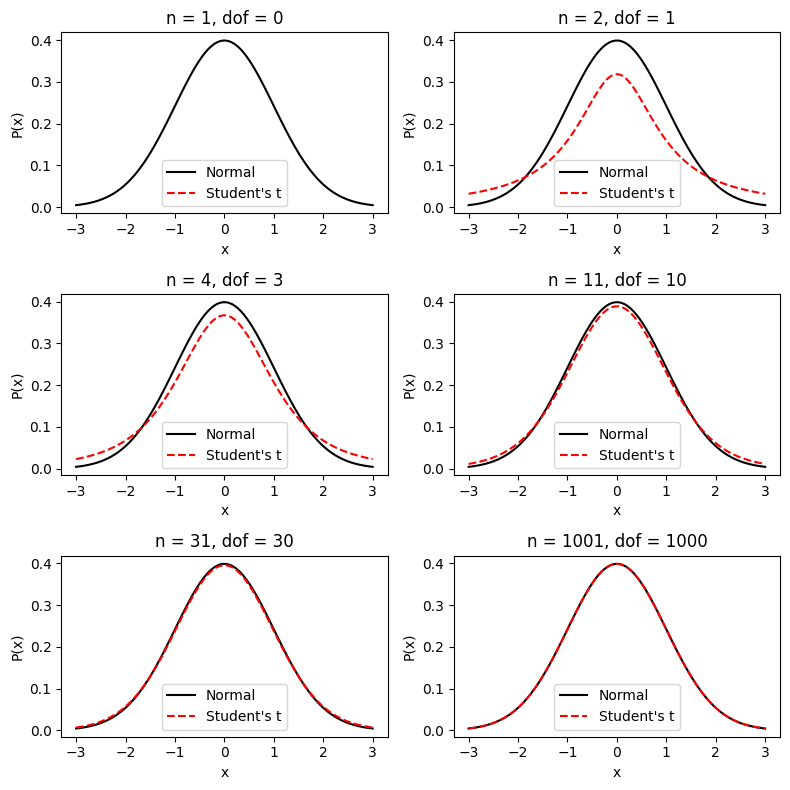

In [84]:
x = np.linspace(-3, 3, 100)                 # x-axis values...
pdf_normal = st.norm.pdf(x)                 # ...and the standard normal PDF at those
degrees_of_freedom = [0, 1, 3, 10, 30, 1000]         # four degrees of freedom to plot

plt.figure(figsize=(8, 8))
for subplot_index, dof in enumerate(degrees_of_freedom):
    pdf_student = st.t.pdf(x, dof)          # Student's t-distribution PDF (for this dof)
    plt.subplot(3, 2, subplot_index + 1)
    plt.title("n = {}, dof = {}".format(dof+1, dof))
    plt.plot(x, pdf_normal, "k-", label="Normal")
    plt.plot(x, pdf_student, "r--", label="Student's t")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.legend(loc="best")
    
plt.tight_layout()
plt.show()

In [87]:
statistic, pvalue = st.ttest_1samp(log_masses, model_mean)
print("Statistic = {:.3g}".format(statistic))
print("p-value   = {:.3g}".format(pvalue))

Statistic = -1.8
p-value   = 0.0753


## The Central Limit Theorem

In the above example we assumed that the mean of the sample is normally-distributed, i.e. following the Gaussian distribution. This is often the case, at least with some approximation due to the **Central Limit Theorem**:

> the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger, no matter what the shape of the population distribution.

Let's take the *arcsine* distribution which does not look like a Gaussian at all...

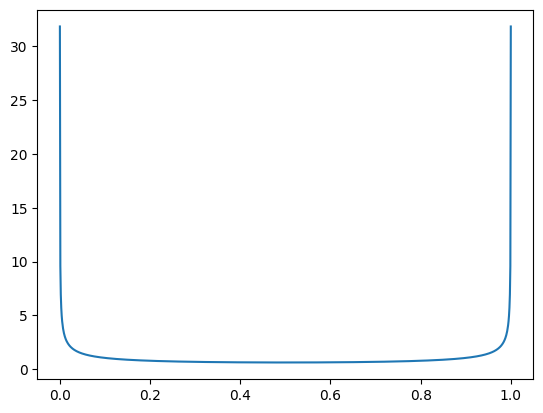

In [177]:
distribution = st.arcsine()
xx = np.linspace(0.0001, 1.0-0.0001, 1000)
plt.figure()
plt.plot(xx, distribution.pdf(xx))
plt.show()

![...](images/thats-just-not-normal.jpg)

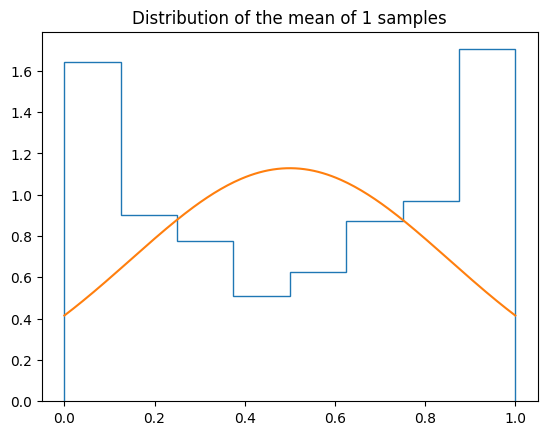

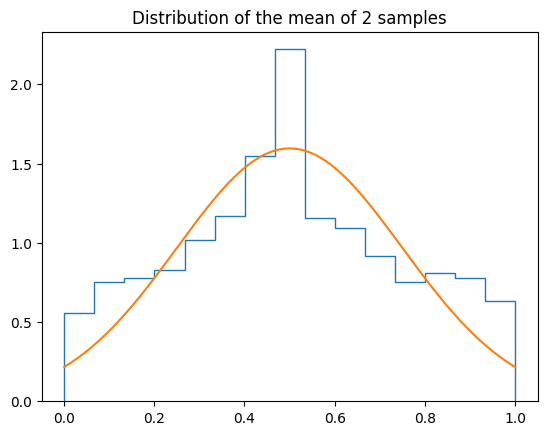

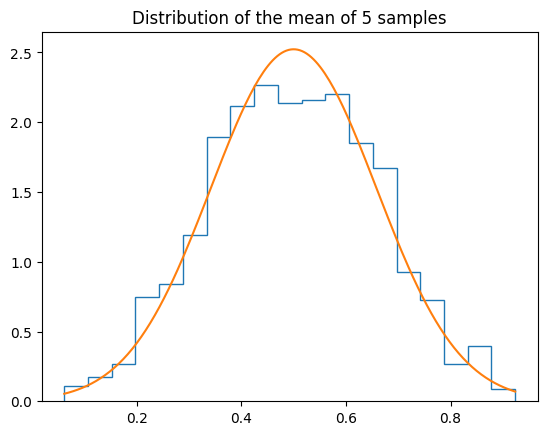

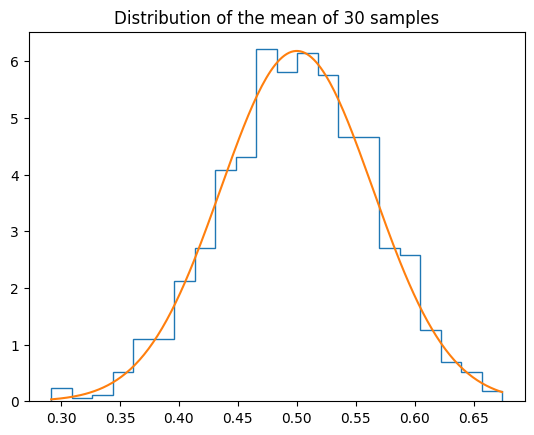

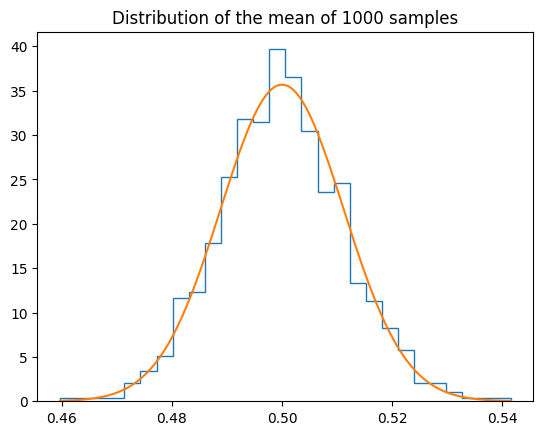

In [90]:
samplings_of_mean = 1000
sample_sizes = [1, 2, 5, 30, 1000]

for sample_size in sample_sizes:
    plt.figure()
    plt.title(f"Distribution of the mean of {sample_size} samples")
    
    sample_means = [np.mean(distribution.rvs(size=sample_size)) for _ in range(samplings_of_mean)]
    plt.hist(sample_means, bins="fd", histtype="step", density=True)

    xx = np.linspace(min(sample_means), max(sample_means), 200)
    plt.plot(xx, st.norm.pdf(xx, distribution.mean(), distribution.std() / sample_size**0.5))

    plt.show()

## Distribution tests

###  Normality test

Above we used our eyes to see the validity of the Central Limit Theorem. But are eyes, and our choice (on bin sizes) may play tricks. Instead, we can test whether a sample follows a known distribution.

In addition, in the hypothesis test at the beginning of the session, we assumed that the data are normally distributed, as well as their mean.

When our analysis depends on the "normality" of a distribution, it is better the perform a hypothesis test for exactly that - a **noramlity test**!

Here we use the **Shapiro-Wilk test for normality** (but it's not the only one out there) to test whether the log-masses of the GCs are following the normal distribution.

We **always have to ask which one is the null hypothesis test when using them as a black box**. For Shapiro-Wilk is:

>  $H_0$: the sample came from a normally distributed population

In [123]:
st.shapiro(log_masses)

ShapiroResult(statistic=0.983458936214447, pvalue=0.38180243968963623)

### Arbitrary distribution test: the K-S test

Note that a normality test, is very specific to the distribution we check against (Gaussin), but not it's parameters. To check for agreement with any distribution, the **Kolmogorov-Smirnov** test can be used.

> $H_0$: the sample is drawn from the reference distribution

The test is measuring the maximum distance between two cumulative distribution functions (from the sample and a model/another sample), which is called $D$ statistic. Depending on the number of samples, the $D$ statistics corresponds to a $p$-value. Let's see how it looks:

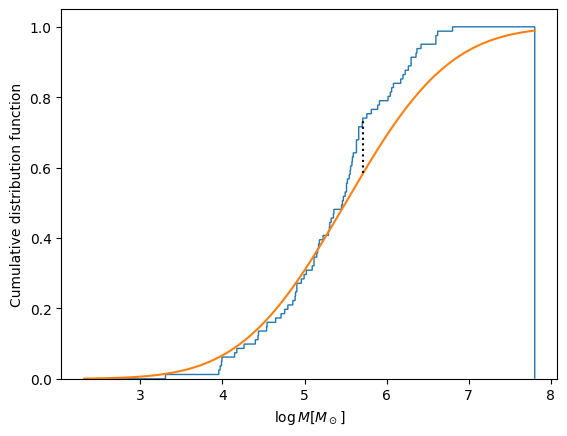

In [101]:
bins = np.linspace(min(log_masses)-1, max(log_masses)+1, 1000)
xx = (bins[1:] + bins[:-1]) / 2.0

model_cdf = st.norm.cdf(xx, loc=model_mean, scale=model_std)
plt.figure()
sample_cdf, _, _ = plt.hist(log_masses, bins=bins, histtype="step", density=True, cumulative=1)
# np.histogram(log_mass, bins=xx, density=True, cumulative=1)

where_max_d = np.argmax(np.abs(model_cdf-sample_cdf))
D1, D2 = model_cdf[where_max_d], sample_cdf[where_max_d]
D = abs(D1 - D2)
plt.plot(xx, model_cdf)
plt.plot([xx[where_max_d]]*2, [D1, D2], "k:", label="D={:.4g}".format(D))
plt.xlabel("$\log M [M_\odot]$")
plt.ylabel("Cumulative distribution function")
plt.show()

In [121]:
# perform the K-S test
model_distribution = st.norm(model_mean, model_std)
st.kstest(log_masses, model_distribution.cdf)

KstestResult(statistic=0.1558856968871586, pvalue=0.03478135019967103, statistic_location=5.714329759745233, statistic_sign=1)

<font size=3><u>**In-class discussion: Why do we get a different $p$-value with the K-S test?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
THe main reason is that the normality test is less conservative than the K-S test! In the K-S test we tested against a specific normal distribution with a defined mean and standard deviation. The normality test is agnostic to these values!
<br>

# Dependence/independence of random variables
Sometimes we want to test whether two quantities are (un)correlated, or *(in)dependent*. This is useful for 
* confirming a model predicting that such a correlation exists
* predicting a quantity (e.g., 'y' from 'x')
* verify a monotonic relation between two quantities

## Correlation tests

In the begining of the chapter, we assumed that the K-band luminosity and the mass are correlated, and therefore the logarithm of the mass is linearly correlated with the absolute magnitude:

$$\Large 
    \begin{cases} 
        M &= \Upsilon L_K \\
        \dfrac{L}{L_\odot} &= 10^{0.4\left(M_{K,\odot}-M_K\right)}
    \end{cases}
    \Rightarrow
    \log (M/M_\odot) = a M_K + b
$$
where the $a$ and $b$ parameters are expressions of the mass-to-light ratio, the solar K-band absolute magnitude, etc.

We can perform an ordinary least-squares fit to get the best-fitting values of $a$ and $b$. The function `linregress` provided by the `scipy` package can be used. It also returns a $p$-value based on the result!  

The documentation reports:
> The p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.


FIT RESULTS:
    slope          : -0.40 +/- 0.01
    intercept      : 1.26 +/- 0.08
    corr. coeff. R : -0.987370
    R squared      : 0.974900
    p-value        : 5.54919e-65


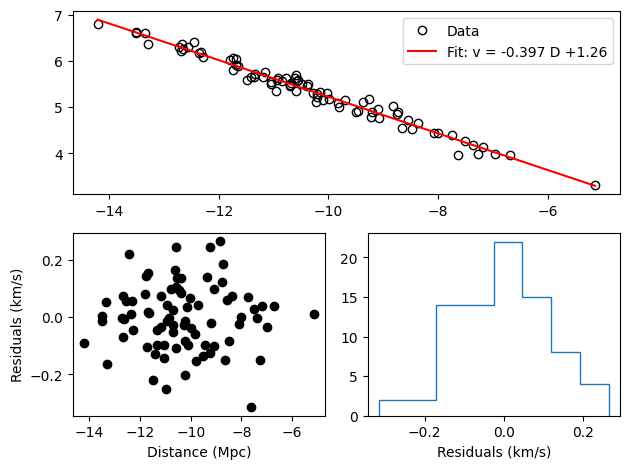

In [118]:
res = st.linregress(x=K_absolute_magnitudes, y=log_masses)

slope, intercept, rvalue, pvalue, slope_stderr = res
intercept_stderr = res.intercept_stderr                # for compatibility this value is extracted like this

print("FIT RESULTS:")
print("    slope          : {:.2f} +/- {:.2f}".format(slope, slope_stderr))
print("    intercept      : {:.2f} +/- {:.2f}".format(intercept, intercept_stderr))
print("    corr. coeff. R : {:.6f}".format(rvalue))
print("    R squared      : {:.6f}".format(rvalue**2.0))
print("    p-value        : {:.6g}".format(pvalue))

x_plot = np.array([min(K_absolute_magnitudes), max(K_absolute_magnitudes)])
y_plot = slope * x_plot + intercept

plt.figure()
plt.subplot(211)
plt.plot(K_absolute_magnitudes, log_masses, "ko", mfc="none", label="Data")
plt.plot(x_plot, y_plot, "r-", label="Fit: v = {:.3g} D {:+.3g}".format(slope, intercept))
plt.legend(loc="upper right")

residuals = log_masses - (slope * K_absolute_magnitudes + intercept)
# plt.figure(constrained_layout=True)
plt.subplot(223)
plt.plot(K_absolute_magnitudes, residuals, "ko")
plt.xlabel("Distance (Mpc)")
plt.ylabel("Residuals (km/s)")
plt.subplot(224)
plt.hist(residuals, bins="fd", histtype="step")
plt.xlabel("Residuals (km/s)")
plt.tight_layout()
plt.show()

Pearson correlation coefficient:

$$ \large \rho = \dfrac{\mathrm{cov}\left(X, Y\right)}{\sigma_X \sigma_Y} $$

For a sample:

$$ \large
    r = \dfrac{
              \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)
              }
              {
              \sqrt{
              \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right)^2
              \sum\limits_{i=1}^{n}\left(y_i - \bar{y}\right)^2
              }
              }
$$

- 0: no correlation. 
- 1: perfect correlation
- -1: perfect anti-correlation.

The square of $r$, usually refered as **R-squared** in the literature, is the *percentage of explained variance through the linear correlation*.

Therfore, a $p$-value smaller than our significance level, means that **we reject the hypothesis that the slope is 0**, which can be rephrased as **we cannot reject the hypothesis that there is a linear correlation**.

**Warning**: this doesn't mean that we accept that the correlation is linear. We get the above result *assuming linear correlation*!


### If we do not need to fit, we can use the `pearsonr` function to perform the hypothesis test

**Warning**: this does not alleviate the caveat that the correlation might not be linear!

In [119]:
st.pearsonr(K_absolute_magnitudes, log_masses)

PearsonRResult(statistic=-0.9873702567487689, pvalue=5.5491936681630286e-65)

## Monotonicity test

Sometimes a linear correlation does not exist! For example, if we had no intuition about the connection between the K-band absolute magnitudes and masses of globular clusters, plotting them we would see a trend! The higher the magnitude, the lower the mass.

The Pearson correlation test would... not be very appropriate without logging the mass! Let's see that:

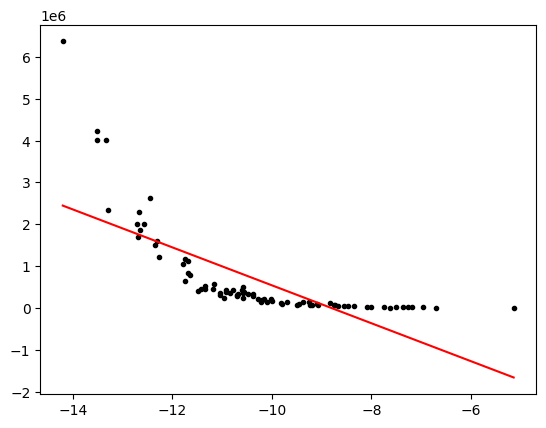

In [154]:
x, y = K_absolute_magnitudes, masses
slope, intercept, _, _, _ = st.linregress(x, y)

xx = np.linspace(min(x), max(x), 100)
plt.figure()
plt.plot(x, y, "k.")
plt.plot(xx, slope * xx + intercept, "r-")
plt.show()

To test for such dependences, we can perform a **monotonicity test**. There are two widely used monotonicity checks through the *Spearman rank correlation coefficient* $r_s$ and the *Kendall rank correlation coefficient* $\tau$ often referred as *Kendall's $\tau$*. Their power relies on the fact that they are *non-parametric* and therefore they do not rely on an assumed model describing the data.

For $r_s$ and $\tau$:
- 0: $x$ and $y$ are independent
- 1: strictly increasing
- -1: strictly decreasing

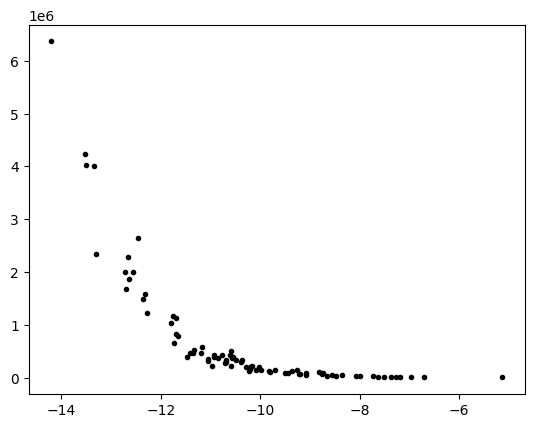

PEARSON  : r = -0.730  |  p-value = 1.08e-14
SPEARMAN : r = -0.980  |  p-value = 4.08e-57
KENDALL  : t = -0.892  |  p-value = 4.36e-32


In [149]:
x, y = K_absolute_magnitudes, masses

plt.figure()
plt.plot(x, y, "k.")
plt.show()
# report correlation tests' p-values
r, pvalue = st.pearsonr(x, y)
print("PEARSON  : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.spearmanr(x, y)
print("SPEARMAN : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.kendalltau(x, y)
print("KENDALL  : t = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))

<font size=3><u>**In-class discussion: How do you interprete the small Pearson's $r$-value?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Despite the fact that the correlation is obvisouly non-linear, even the wrong model has to have a non-zero slope! Always remember your $H_0$ hypothesis! 
<br>

Let's try with a subset of the data...

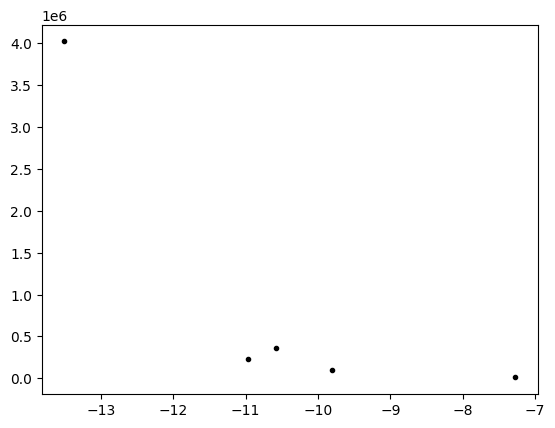

PEARSON  : r = -0.806  |  p-value = 0.0993
SPEARMAN : r = -0.900  |  p-value = 0.0374
KENDALL  : t = -0.800  |  p-value = 0.0833


In [176]:
subset_size = 5
random_subset = np.random.choice(len(masses), size=subset_size)

x, y = K_absolute_magnitudes[random_subset], masses[random_subset]

plt.figure()
plt.plot(x, y, "k.")
plt.show()
# report correlation tests' p-values
r, pvalue = st.pearsonr(x, y)
print("PEARSON  : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.spearmanr(x, y)
print("SPEARMAN : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.kendalltau(x, y)
print("KENDALL  : t = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))

<font size=3><u>**In-class discussion: Run it many times. Do you notice differences in the Spearman and Kendall $p$-values?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Kendall's $p$-values are never too extreme! In general, it is a more robust method!
<br>

# In-class Exercises

- They should have a dedicated chapter, sub-chapter or sub-sub-chapter

- The **in-class** notebook shall have three dots "`...`" to signify where to fill in stuff

- The **answerkey notebook** shall have the _exact same_ fill-in block(s) followed by a separation, and finally "`Our solution`"

- They must use the following formatting (the example is for an answerkey notebook)

## In-class Exercise: _Do-this-and-that-example_

**Task.** Apply regularization.

**Objective**: Keep the best network you found previously, and add regularization.  Observe how the convergence changes by using regularization.

Add the regularizations one by one, and re-run every time to see what happens.  Use one or more of:
1. L1 or L2 regularization
2. Batch Normalization
3. Dropout

**Dataset**: We will use the same dataset as before.

<hr style='height:1px'>

_Our solution_

## In-class Discussion Example

<font size=3><u>**In-class discussion**</u><font>

What would you do to fit a Gaussian?
    
_Discuss a few mins with your teammate, then report.  Think of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Here goes a hint or the solution.
<br>